# Combinatorial Purged Cross-Validation (M. Lopez de Prado)

- Index plotting function (copied from sklearn)

In [ ]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10, title = None):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["target", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    if title is None:
        ax.set_title("{} Cross-Validation".format(type(cv).__name__), fontsize=15)

    else:
        ax.set_title(title, fontsize=15)

    return ax

- Generate random sample data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

# Generate the class/group data
n_points = 100
X = rng.randn(100, 10)

percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Generate uneven groups
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))

## Traditional methods of cross validation

In [ ]:
# Define sample time-series indexes of data
data = list(range(1,11))
print(data)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [ ]:
from sklearn.model_selection import train_test_split

# Implement train/test split
train_test_split(data, train_size=0.8)

[[6, 5, 7, 2, 3, 8, 9, 4], [1, 10]]

### K-Fold Cross-Validation

[2 3 4 5 6 7 8 9] [0 1]
[0 1 4 5 6 7 8 9] [2 3]
[0 1 2 3 6 7 8 9] [4 5]
[0 1 2 3 4 5 8 9] [6 7]
[0 1 2 3 4 5 6 7] [8 9]


<Axes: title={'center': 'KFold Cross-Validation'}, xlabel='Sample index', ylabel='CV iteration'>

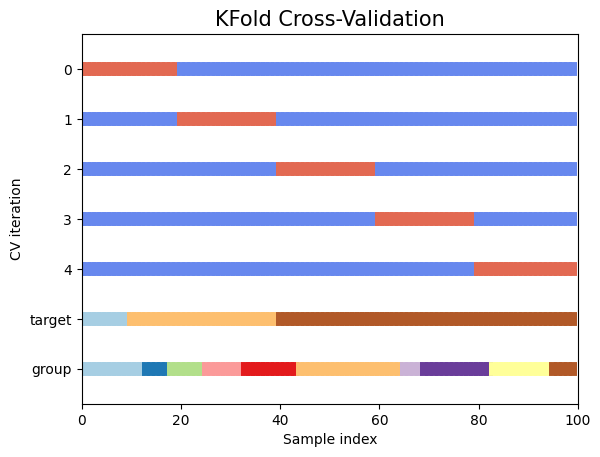

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
for train, validate in kf.split(data):
    print(train, validate)
    pass

n_splits = 5
fig, ax = plt.subplots()
plot_cv_indices(kf, X, y, groups, ax, n_splits)

### Shuffling index

[0 2 3 4 5 6 7 9] [1 8]
[1 2 3 4 6 7 8 9] [0 5]
[0 1 3 4 5 6 8 9] [2 7]
[0 1 2 3 5 6 7 8] [4 9]
[0 1 2 4 5 7 8 9] [3 6]


<Axes: title={'center': 'KFold Cross-Validation'}, xlabel='Sample index', ylabel='CV iteration'>

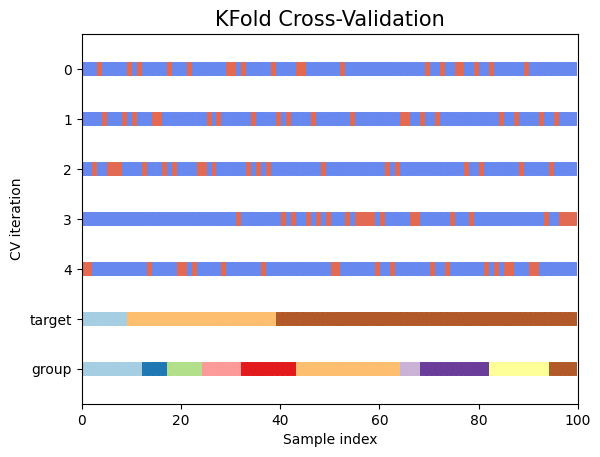

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train, validate in kf.split(data):
    print(train, validate)
    pass

n_splits = 5
fig, ax = plt.subplots()
plot_cv_indices(kf, X, y, groups, ax, n_splits)

## Time-Series Cross-Validation

To address time dependency, the TimeSeriesSplit object implements a walk-forward
test with an expanding training set, where subsequent training sets are supersets of past
training sets

[0 1 2 3 4] [5]
[0 1 2 3 4 5] [6]
[0 1 2 3 4 5 6] [7]
[0 1 2 3 4 5 6 7] [8]
[0 1 2 3 4 5 6 7 8] [9]


<Axes: title={'center': 'TimeSeriesSplit Cross-Validation'}, xlabel='Sample index', ylabel='CV iteration'>

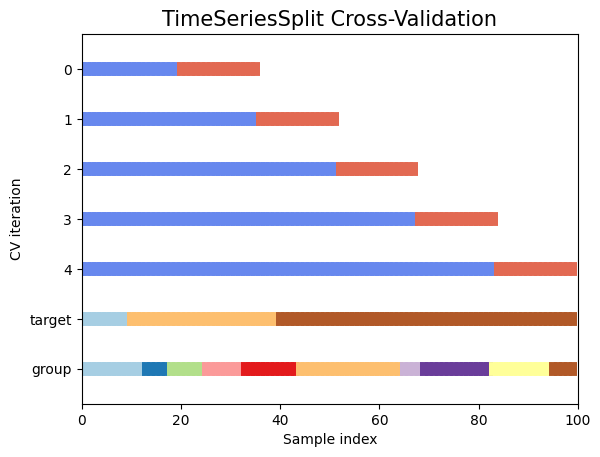

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train, validate in tscv.split(data):
    print(train, validate)
    pass

n_splits = 5
fig, ax = plt.subplots()
plot_cv_indices(tscv, X, y, groups, ax, n_splits)

### Train/Validation/Test Split

Model selection often involves hyperparameter tuning, which may result in many CV
iterations. The resulting validation score of the best-performing model will be subject to
multiple testing bias, which reflects the sampling noise inherent in the CV process. As a
result, it is no longer a good estimate of the generalization error. For an unbiased estimate
of the error rate, we have to estimate the score from a fresh datastimate.

For this reason, we use a three-way split of the data, as shown in Figure 6.10: one part
is used in cross-validation and is repeatedly split into a training and validation set. The
remainder is set aside as a hold-out set that is only used once after, cross-validation is
complete to generate an unbiased test error estimate.

## Preventing Data Leakage

The risks include the leakage of information from the test into the training set, which would
very likely artificially inflate performance. We need to address this risk by ensuring that all
data is point-in-time—that is, truly available and known at the time it is used as the input
for a model. For example, financial disclosures may refer to a certain time period but only
become available later. If we include this information too early, our model might do much
better in hindsight than it would have under realistic circumstances.

### Purging - cutting last observations from training set

*Definition*:
Purging involves removing data points from the training set that are in close temporal proximity to data points in the test set. In particular, this means removing all samples from train set which would be evaluated on actual data that lies in training set

*Purpose*: The goal of purging is to ensure that information from the future (test set) does not leak into the past (training set). In financial time series, this is crucial because future information should not be available when predicting past values.

![purging_embargoing.png](attachment:c3e8fd1b-67ae-4221-856a-9f147d55fec0.png)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args # This decorator simply enforces user to use keyword arguments only (ie. positional arguments without a key will throw an error)
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]

                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size

            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]


            if self.verbose > 0:
                    pass

            yield [int(i) for i in train_array], [int(i) for i in test_array]

Lenght of CV [Train - 1]: 40
Length of CV [Validate - 1]: 9
Lenght of CV [Train - 2]: 40
Length of CV [Validate - 2]: 9
Lenght of CV [Train - 3]: 40
Length of CV [Validate - 3]: 9
Lenght of CV [Train - 4]: 40
Length of CV [Validate - 4]: 9
Lenght of CV [Train - 5]: 40
Length of CV [Validate - 5]: 9


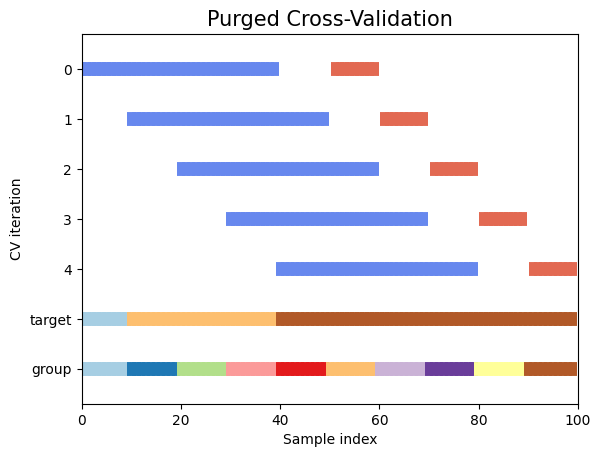

In [ ]:
cv = PurgedGroupTimeSeriesSplit(
    n_splits=5, # Number of Cross-Validation splits
    max_train_group_size=4, # Maximum training size at 70% of input data
    group_gap=1, # Skip rows of observations for last group in the training sample
    max_test_group_size=3 # Maximum test size at 30% of input data
)

n_samples = 100
n_groups = 10
groups = np.repeat(np.linspace(0, n_groups-1, num=n_groups), n_samples/n_groups)

n_splits = 5
fig, ax = plt.subplots()
plot_cv_indices(cv, X, y, groups, ax, n_splits, title='Purged Cross-Validation')

idx = 0
for train, validate in cv.split(X=X, y=y, groups=groups):
    print(f'Lenght of CV [Train - {idx+1}]: {len(train)}')
    print(f'Length of CV [Validate - {idx+1}]: {len(validate)}')
    idx += 1
    pass

## Embargo:  From Walk-Forward to Shuffled K-Fold

### Embargoing - cutting first training observations after test set

- Using exactly the same set of training (train + validate) data, we can now reshuffle the order of data, and produce different CV folds
- Similarly to purging, we will create a gap between train and validation sets, only this time after the validation "block" ends in fold

For those cases where purging is not able to prevent all leakage, we can impose
an embargo on training observations after every test set.
The embargo does not affect training observations prior to a test set

![embargo.png](attachment:0e22e4e8-fd16-4d53-bfaf-f84df4b38e4e.png)

In [ ]:
from sklearn.model_selection._split import _BaseKFold
class PurgedKFold(_BaseKFold):
    """
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    """
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo

    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')

        # TODO: grouping function combinations insert here??
        # manage groups by using label in dataframe?
        # use combinations + group label to split into chunks??

        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[
            (i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]),
                                                   self.n_splits)
        ]
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j]
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx<X.shape[0]: # right train ( with embargo)
                train_indices=np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

In [ ]:
import pandas as pd
X_df = pd.DataFrame(X)
date_series = pd.Series(range(100))

<Axes: title={'center': 'Embargoed (Shuffled) Cross-Validation'}, xlabel='Sample index', ylabel='CV iteration'>

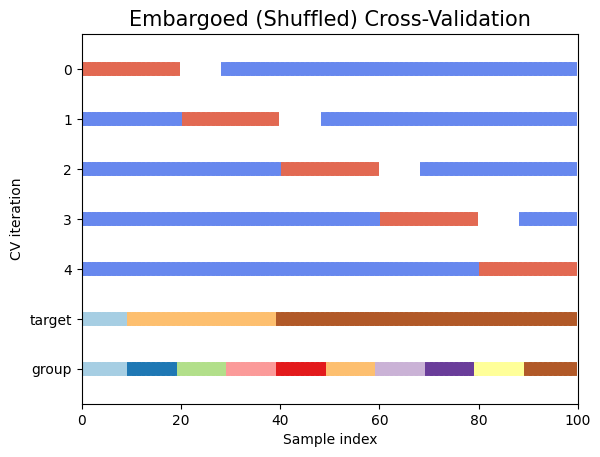

In [ ]:
purged_cv = PurgedKFold(
    n_splits = 5,
    t1 = date_series,
    pctEmbargo = 0.1
)

n_samples = 100
n_groups = 10
groups = np.repeat(np.linspace(0, n_groups-1, num=n_groups), n_samples/n_groups)

n_splits = 5
fig, ax = plt.subplots()
plot_cv_indices(purged_cv, X_df, y, groups, ax, n_splits, title = 'Embargoed (Shuffled) Cross-Validation')

## Putting all together CPCV (Combinatorial Purged K-fold Cross-Validation)

Once we've seen both *Purging* and *Embargoing* in action, we can move to CV method to backtest Time-Series model using De-Prado's approach

Since we now allow shuffling our CV Folds, we will use *Combinatorial* framework in following way:
1. Maximize number of different paths (ie. scenarios), by compiling number of all possible combinations (Purged & Embargoed periods are labeled with red)

![ComBinatorialPurgedKfoldCV.png](attachment:f99febe7-a139-457f-b178-9e0ab8b1951e.png)

2. From all generated (artificial) paths, filter out ones that contain duplicated/overlapping connections between Train (blue) and Test (orange) Folds

This can be achieved by using following selection method (this is example of n_folds=5)

![PurgedCVPathSelection.png](attachment:9fc46594-a577-4ca2-8b88-7e3272c9b2f8.png)